# Bullish engulfing with lowest low - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-10-21 14:10:00,1927.5,1933.0,1918.7,1922.0,16658
2025-10-21 14:15:00,1922.0,1927.5,1919.2,1921.5,8361
2025-10-21 14:20:00,1921.5,1926.0,1902.9,1906.7,16009


In [8]:
data["bullish_engulfing"] = (
    (data["Close"] > data["Open"]) &
    (data["Close"].shift(1) < data["Open"].shift(1)) &
    (data["Close"] > data["Open"].shift(1) + 0.69 * (data["Close"].shift(1) - data["Open"].shift(1)))
)


In [11]:
data["min_15"] = data["Low"].shift(1).rolling(15).min()
data["fit"] = ((data["Low"] < data["min_15"]) & (data["bullish_engulfing"] == True))

### Calculate Risk & Reward

In [13]:
%%time
data['risk'] = None
data['reward'] = None
for i, row in data.iterrows():
    if row['fit'] == True:
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        entry_price = row['Close']
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date+' 14:30:00')]
        max_price = entry_price
        min_price = entry_price
        for k, wrow in data_to_end_day.iterrows():
            if wrow['Low'] < min_price:
                min_price = wrow['Low']
            if wrow['High'] > max_price:
                max_price = wrow['High']
            # Long
            risk = entry_price - min_price
            reward = max_price - entry_price
        data.at[i, 'risk'] = risk
        data.at[i, 'reward'] = reward

CPU times: user 5.13 s, sys: 13.8 ms, total: 5.14 s
Wall time: 5.15 s


In [17]:
data[data.fit==True]

,Open,High,Low,Close,Volume,bullish_engulfing,min_15,fit,risk,reward
Date,,,,,,,,,,
2018-08-15 13:10:00,955.4,955.9,954.7,955.9,2478,True,955.2,True,6.0,4.0
2018-08-16 09:30:00,940.6,941.8,940.6,941.8,1634,True,940.8,True,6.3,5.5
2018-08-16 11:00:00,936.7,937.5,935.6,937.3,2542,True,936.3,True,1.8,10.0
2018-08-16 11:15:00,936.3,937.1,935.5,937.1,1260,True,935.6,True,0.6,10.2
2018-08-22 10:35:00,958.2,958.8,958.0,958.7,1651,True,958.1,True,5.1,1.5
...,...,...,...,...,...,...,...,...,...,...
2025-10-17 13:40:00,1997.4,1998.6,1995.0,1998.0,7011,True,1996.2,True,38.0,2.4
2025-10-17 14:00:00,1982.9,1990.9,1968.6,1986.9,18689,True,1982.1,True,26.9,1.4
2025-10-20 10:35:00,1952.9,1957.5,1950.2,1957.1,7068,True,1952.2,True,95.1,8.8


### Phân tích mối quan hệ Risk/Reward

In [14]:
df1 = data[["Open", "Close", "High", "Low", "fit", "risk", "reward"]].copy()
df1["risk"] = df1["risk"].astype(float)
df1["reward"] = df1["reward"].astype(float)
df1.dropna(inplace=True)
df1_fit = df1[df1.fit==True]

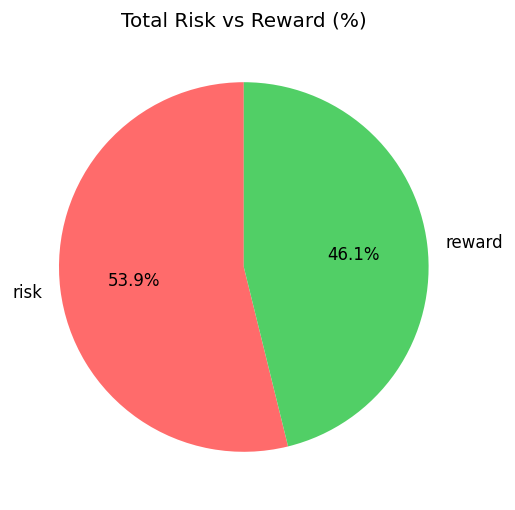

In [15]:
sum_values = df1_fit[["risk", "reward"]].sum()

plt.figure(figsize=(5, 5))
plt.pie(
    sum_values,
    labels=sum_values.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#FF6B6B", "#51CF66"]
)
plt.title("Total Risk vs Reward (%)")
plt.show()

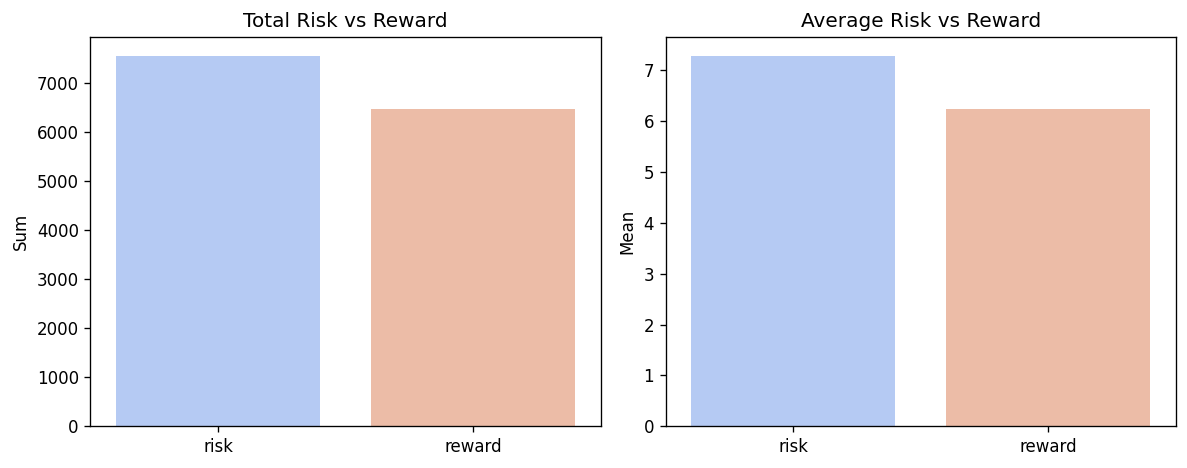

In [16]:
sum_df = df1_fit[["risk", "reward"]].sum().reset_index(name="value")
mean_df = df1_fit[["risk", "reward"]].mean().reset_index(name="value")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=sum_df, x="index", y="value", ax=axes[0], palette="coolwarm")
axes[0].set_title("Total Risk vs Reward")
axes[0].set_xlabel("")
axes[0].set_ylabel("Sum")

sns.barplot(data=mean_df, x="index", y="value", ax=axes[1], palette="coolwarm")
axes[1].set_title("Average Risk vs Reward")
axes[1].set_xlabel("")
axes[1].set_ylabel("Mean")

plt.tight_layout()
plt.show()